In [7]:
## Robotics WS 18/19
## Assignment 5 Solution
## by Pascal Müller, Friedrich Müller, Fabian Casares

#####################################################################


import numpy as np
import matplotlib.pyplot as plt
import cv2
import math

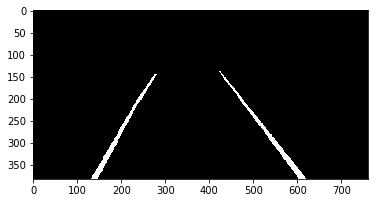

In [3]:
#Opening Image and converting it to grayscale
img = cv2.imread('lines_u5.jpeg',cv2.IMREAD_COLOR)
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray= cv2.cvtColor(RGB_img, cv2.COLOR_RGB2GRAY)

#Some cropping because the image file is a screenshot. This can be ommited if you pull the image directly from a channel
# gray=gray[500:800,70:800]

#binarizing image
bi_gray_max = 255
bi_gray_min = 200
ret,thresh=cv2.threshold(gray, bi_gray_min, bi_gray_max, cv2.THRESH_BINARY)

#We know pixels can only be 0 or 255 because of binarization
whiteDots = np.argwhere(thresh>0)
#Also Indices come as (y,x) out of argwhere, but we want (x,y)
whiteDots = whiteDots[:,::-1]

def printWhiteDots(whiteDots, canvasShape):
    canvas=np.zeros(canvasShape)
    canvas[whiteDots[:,1],whiteDots[:,0]]=255
    plt.imshow(canvas, cmap='gray')
    plt.show()

printWhiteDots(whiteDots,thresh.shape)

In [4]:
#Distance from point (x_0,y_0) to a line by = -ax - c is given by:
#https://en.wikipedia.org/wiki/Distance_from_a_point_to_a_line#Line_defined_by_an_equation
class LineModel():
    
    def __init__(self, point1, point2):

        #We can now calculate the slope m from the points. From that we get a
        self.m = (point1[1]-point2[1])/(point1[0]-point2[0])
        self.a = -self.m
        
        #We can now rearrange the formula to c= -ax -by and insert one of our points to calculate c.
        self.c = -self.a*point1[0] -point1[1]
        #This b is not the same as in the formula! we ignore the b in the formula becuase it is 1. This b here is the offset of the function
        self.b = -self.c
        
        #Now we prepare the denominator of the formula's fraction for later use (it only depends on constants)
        self.denominator = math.sqrt(pow(self.a,2)+1)
    
    def dist(self, point):
        #Here we just apply the formula as found in the link above
        return abs(self.a*point[0] + point[1] + self.c)/self.denominator

In [5]:
def ransac(whiteDotSet, percentageThreshold, distanceThreshold, iterations=10):  
    bestCandidateSet = None
    antiSetOfBestSet = None
    bestModel = None
    #Percentage means percentage of dots inside the distance threshold of a model line
    bestPercentage = 0
    
    for j in range(0,iterations):
        twoRands = np.random.randint(0, len(whiteDotSet),2)
        #Haven't found a better way to avoid choosing the same point twice
        if twoRands[0] == twoRands[1]:
            continue
        
        dotA, dotB = whiteDotSet[twoRands[0]], whiteDotSet[twoRands[1]]
        
        #A model for a line that goes through dotA and dotB
        ln = LineModel(dotA, dotB)
        
        def closeEnough(dot):
            return ln.dist(dot)<distanceThreshold

        #Using numpy feature "Boolean Indexing"
        boolSet = np.apply_along_axis(func1d=closeEnough, axis=1, arr=whiteDotSet)
        consensusSet= whiteDotSet[boolSet]

        percentageActual=len(consensusSet)/len(whiteDotSet)

        if(percentageActual>percentageThreshold and percentageActual>bestPercentage):  
            bestCandidateSet = consensusSet
            antiSetOfBestSet = whiteDotSet[np.logical_not(boolSet)]
            bestModel = ln
            bestPercentage = percentageActual
    
    return bestCandidateSet, antiSetOfBestSet, bestModel

Line Model: y=1.3548387096774193*x + -435.0645161290322


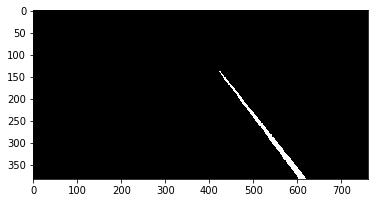

Line Model: y=-1.5*x + 566.0


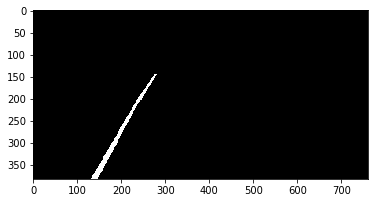

In [6]:
lineA, notLineA, lineAModel = ransac(whiteDots,percentageThreshold=0.3, distanceThreshold=20)
print("Line Model: y={}*x + {}".format(lineAModel.m,lineAModel.b))
printWhiteDots(lineA, canvasShape=thresh.shape)
lineB, notLineB, lineBModel = ransac(notLineA,percentageThreshold=0.8, distanceThreshold=20)
print("Line Model: y={}*x + {}".format(lineBModel.m,lineBModel.b))
printWhiteDots(lineB, canvasShape=thresh.shape)